In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# загружаем требуемые библиотеки
import numpy as np
import pandas as pd
from numpy.random import default_rng
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding
from statsmodels.tsa.stattools import adfuller

In [3]:
# загрузим те же данные, что сгенерированы в R
df = pd.read_csv('E_save_1.csv',header=None)
E = df.iloc[:,0]

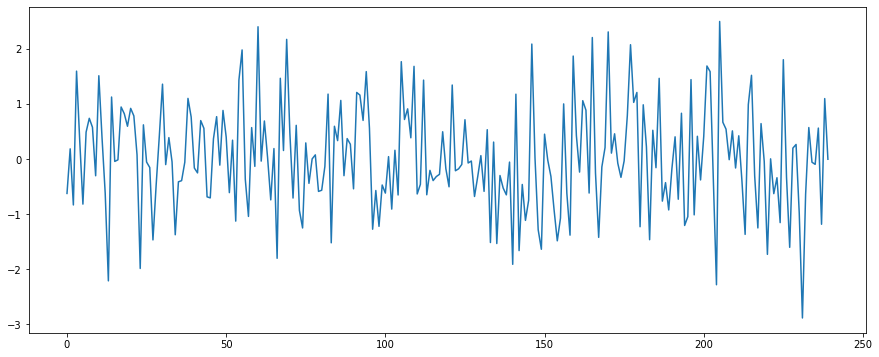

In [4]:
# Посмотрим на них
E.plot(figsize=(15, 6))
plt.show()

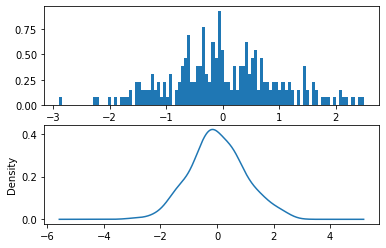

In [5]:
# Посмотрим на распределение их
plt.figure(1)
plt.subplot(211)
plt.hist( E, 100, density=True)
plt.subplot(212)
E.plot(kind='kde')
plt.show()

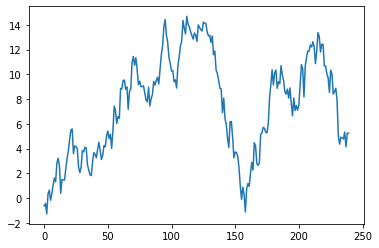

In [6]:
# создаем набор X с кумулятивными данными 
X=np.cumsum(E)
# посмотрим на них
plt.plot(X)

# Стандартный тест Дики – Фуллера

Дики Фуллер (стандарт)
Здесь для простой версии теста Дики-Фуллера мы предполагаем, что


и мы хотели бы проверить, есть ли (или нет). 

Мы можем записать предыдущее представление как


поэтому нам просто нужно проверить, равен ли коэффициент регрессии в линейной регрессии нулю или нет. 

Что можно сделать с помощью теста Стьюдента. 

Если мы рассмотрим предыдущую модель без линейного дрейфа, мы должны рассмотреть следующую регрессию :

In [7]:
lags=0
# ряд первых разностей 
z=np.diff(X)
n=len(z)

In [8]:
# аналог действия 
# embed(z, lags+1)[,1]  
# в языке R
STE = SingleTakensEmbedding(parameters_type="fixed", time_delay=1, dimension=lags+1)
z_diff = STE.fit_transform(z)[:,-1]

In [9]:
zlag1 = X[lags:n]
zlag1 = np.array(zlag1).reshape(-1, 1)

In [10]:
lm = LinearRegression(fit_intercept=False)
lm.fit(zlag1,z_diff)

LinearRegression(fit_intercept=False)

## Найдем t-критерий стьюдента

In [11]:
# Найдем t-критерий стьюдента
params = lm.coef_ 
predictions = lm.predict(zlag1)
MSE = (sum((z_diff-predictions)**2))/(len(zlag1)-len(zlag1[0]))
var_b = MSE*(np.linalg.inv(np.dot(zlag1.T,zlag1)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
print("t-критерий Стьюдента = " , np.round(ts_b,3))

t-критерий Стьюдента =  [-0.766]


In [12]:
# Однако проще построить нашу модель линейной регрессии 
# и найти ее характеристики, включая t-критерий, 
# используя пакет statsmodelsиспользуя и его функцию OLS
# т.е. - statsmodels.regression.linear_model.OLS
model = sm.OLS(zlag1,z_diff)
model

In [13]:
# подгоним модель
result = model.fit()
# и посмотрим все статистики
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.002
Model:                            OLS   Adj. R-squared (uncentered):             -0.002
Method:                 Least Squares   F-statistic:                             0.5873
Date:                Thu, 26 Aug 2021   Prob (F-statistic):                       0.444
Time:                        17:16:16   Log-Likelihood:                         -850.61
No. Observations:                 239   AIC:                                      1703.
Df Residuals:                     238   BIC:                                      1707.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.4388      0.573     -0.766      0.444      -1.567       0.689
==============================================================================
Omnibus:                       55.284   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.812
Skew:                          -0.139   Prob(JB):                      0.00272
Kurtosis:                       1.947   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [14]:
# посмотрим отдельно t-критерий Стьюдента
result.t_test([1])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.4388      0.573     -0.766      0.444      -1.567       0.689

In [15]:
# или так :
result.tvalues[0]

-0.766330810487498

# И это значение соответствует значению, вычисленному с использованием специализированных библиотек.
 # Eсть несколько пакетов, которые можно использовать для модульных корневых тестов:

### Например с помощью библиотеки arch (https://github.com/bashtage/arch) :

In [16]:
from arch.unitroot import ADF

ADF(X, trend="n", lags=0)

Test Statistic,-0.766
P-value,0.385
Lags,0


### Или тест Дики-Фуллера с помощью библиотеки statsmodels :

In [17]:
# Или тест Дики-Фуллера с помощью библиотеки statsmodels :
result = adfuller(X, maxlag=0, autolag=None, regression='nc')# “nc” : no constant, no trend.
#print('ADF Statistic: %f' % result[0])
print('t-статистика(статистика Дики — Фуллера): %f' % result[0])

t-статистика(статистика Дики — Фуллера): -0.766331


## Интерпретация этого значения может быть сделана с использованием критических значений  статистики Дики — Фуллера при 1%,5%,10%-ном уровне значимости

In [18]:
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

Критические значения:
	1%: -2.575
	5%: -1.942
	10%: -1.616


Если статистика превышает эти значения, то ряд не является стационарным, 
поскольку мы не можем отвергнуть предположение, что


    
Таким образом, мы можем заключить, что существует единичный корень.

In [19]:
if result[0] < result[4]["5%"]:
    print ("ряд является стационарным")
else:
    print ("ряд НЕ является стационарным")

ряд НЕ является стационарным


#  Дополненный тест Дики Фуллер

In [20]:
lags=1
z=np.diff(X)
n=len(z)

In [21]:
# аналог действия  embed(z, lags+1)[,1]   в языке R
STE = SingleTakensEmbedding(parameters_type="fixed", time_delay=1, dimension=lags+1)
zd = STE.fit_transform(z) # в R это - embed(z, lags+1)

In [22]:
z_diff = zd[:,-1]

In [23]:
zlag1 = X[lags:n]
zlag1 = np.array(zlag1).reshape(-1, 1)

In [24]:
# k=lags+1
# z.diff.lag = embed(z, lags+1)[, 2:k]

k=lags+1
# лаги первых разностей
z_diff_lag = zd[:,0:k-1]

In [25]:
# Найдем t-критерий Стьюдента 
# построив модель линейной регресси 
# используя пакет statsmodelsиспользуя и его функцию OLS
# т.е. - statsmodels.regression.linear_model.OLS

In [26]:
model = sm.OLS(z_diff, np.append( zlag1, z_diff_lag,  axis=1))
results = model.fit()
results.t_test([1, 0])

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0054      0.007     -0.733      0.464      -0.020       0.009

In [27]:
# Т.е. t-критерий Стьюдента :
results.tvalues[0]

-0.7328137918714148

In [28]:
# Или вычисленим с помощью библиотеки arch:
from arch.unitroot import ADF

ADF(X, trend="n", lags=1)

Test Statistic,-0.733
P-value,0.399
Lags,1


In [29]:
# Или применим тест Дики-Фуллера с помощью библиотеки statsmodels :
result = adfuller(X, maxlag=1, autolag=None, regression='nc') # “nc” : no constant, no trend.
#print('ADF Statistic: %f' % result[0])
print('t-статистика(статистика Дики — Фуллера): %f' % result[0])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

t-статистика(статистика Дики — Фуллера): -0.732814
Критические значения:
	1%: -2.575
	5%: -1.942
	10%: -1.616


In [30]:
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("ряд является стационарным")
else:
    print ("ряд НЕ является стационарным")

Критические значения:
	1%: -2.575
	5%: -1.942
	10%: -1.616
ряд НЕ является стационарным


# Дополненный тест Дики-Фуллера с трендом и дрейфом

### До сих пор мы не включали дрейф в нашу модель. Но сделать это просто (это будет называться расширенной версией предыдущей процедуры): нам просто нужно включить константу в регрессию,

In [42]:
zlzd = np.append(zlag1, z_diff_lag,  axis=1)
zlzd = np.append( np.ones((len(zlzd),1)) , zlzd,  axis=1)

In [32]:
model = sm.OLS(z_diff, zlzd)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.782
Date:                Thu, 26 Aug 2021   Prob (F-statistic):             0.0639
Time:                        17:16:17   Log-Likelihood:                -326.15
No. Observations:                 238   AIC:                             658.3
Df Residuals:                     235   BIC:                             668.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2918      0.132      2.218      0.028       0.033       0.551
x1            -0.0356      0.015     -2.304      0.022      -0.066      -0.005
x2            -0.0198      0.065     -0.305      0.760      -0.147       0.108
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.929   Jarque-Bera (JB):                0.046
Skew:                           0.029   Prob(JB):                        0.977
Kurtosis:                       3.035   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
# Т.е. t-статистика(статистика Дики — Фуллера):
results.tvalues[1]

-2.303947639922815

In [34]:
# F-статистика :
results.fvalue

2.782361564176448

# Здесь интересующие статистические данные получены с учетом некоторого анализа выходных отклонений, в котором эта модель сравнивается с моделью без интегрированной части и дрейфа

In [35]:
df = pd.DataFrame(z_diff, columns=["z_diff"])
df["zlag1"] = zlag1
df["z_diff_lag"] = z_diff_lag

In [51]:
m01 = smf.ols('z_diff ~ 0 + z_diff_lag', data=df).fit()
m02 = smf.ols('z_diff ~ zlag1 + 1 + z_diff_lag', data=df).fit()
anovaResults = anova_lm(m01, m02, test="F") # "F", "Chisq", "Cp"}or None)
print(anovaResults)

   df_resid         ssr  df_diff   ss_diff         F    Pr(>F)
0     237.0  220.988154      0.0       NaN       NaN       NaN
1     235.0  215.965061      2.0  5.023094  2.732912  0.067097


In [39]:
# Или вычисленим с помощью библиотеки arch:
from arch.unitroot import ADF

ADF(X, trend="c", lags=1)

Test Statistic,-2.304
P-value,0.171
Lags,1


In [40]:
# Или применим тест Дики-Фуллера с помощью библиотеки statsmodels :
result = adfuller(X, maxlag=1, autolag=None, regression='c') # “c” : constant, no trend.
#print('ADF Statistic: %f' % result[0])
print('t-статистика(статистика Дики — Фуллера): %f' % result[0])
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

t-статистика(статистика Дики — Фуллера): -2.303948
Критические значения:
	1%: -3.458
	5%: -2.874
	10%: -2.573


In [41]:
print('Критические значения:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0] < result[4]["5%"]:
    print ("ряд является стационарным")
else:
    print ("ряд НЕ является стационарным")

Критические значения:
	1%: -3.458
	5%: -2.874
	10%: -2.573
ряд НЕ является стационарным
